In [24]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [25]:
#
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
from io import StringIO
from itertools import combinations
import seaborn as sns
from IPython import display

%matplotlib inline
pd.set_option("display.max_rows", 200)
plt.style.use("fivethirtyeight")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["font.size"] = 10

<IPython.core.display.Javascript object>

['Nigeria', 'Poland', 'Denmark', 'Ecuador', 'Cameroon', 'Argentina', 'Cyprus', 'Spain', 'Tunisia', 'Ireland', 'Lebanon', 'Gabon', 'Zambia', 'China', 'Qatar', 'Chile', 'Nepal', 'Portugal', 'Brazil', 'Indonesia', 'Italy', 'Hungary', 'Lithuania', 'Honduras', 'Ethiopia', 'Bahrain', 'Peru', 'Tanzania', 'Estonia', 'Romania']


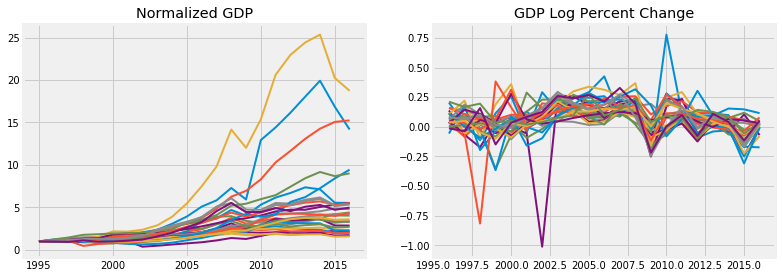

<IPython.core.display.Javascript object>

In [328]:
#
with open("world_gdp.txt") as f:
    lines = [line for line in f.readlines() if line.count(",") == 3]
    df = pd.read_csv(StringIO("".join(lines)))
    df.columns = ["name", "code", "year", "gdp"]
    p = df.pivot_table(values="gdp", index="year", columns="name")
    p = p.loc[1995:].dropna(axis=1)
    p = p[[c for c in p.columns if len(c) < 10 and "." not in c and " " not in c]]
    p = p.loc[:, p.mean() > 1e10]

num_countries = 30
countries = np.random.choice(p.columns, num_countries, replace=False).tolist()
treats = countries[:6]
controls = [c for c in countries if c not in treats]

p = p[countries]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
(p / p.iloc[0]).plot(ax=ax[0])
data = p.pct_change().dropna().applymap(lambda x: np.log(1 + x))
data.plot(ax=ax[1])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
ax[0].set_title("Normalized GDP"), ax[1].set_title("GDP Log Percent Change")
ax[0].set_xlabel(""), ax[1].set_xlabel("")
print(countries)

In [329]:
valid_year = 2004
treat_year = 2010
train = data.loc[:valid_year]
valid = data.loc[valid_year + 1 : treat_year]
test = data.loc[treat_year + 1 :]

energy_threshold = 0.95
# make denoised train
U, s, V = np.linalg.svd((train) - np.mean(train))
energy = np.cumsum(s ** 2) / np.sum(s ** 2)
num_singular_values = np.where(energy >= energy_threshold)[0][0] + 1

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Singular value spectrum')

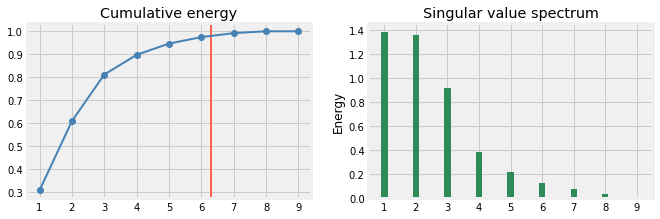

<IPython.core.display.Javascript object>

In [330]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
x_ticks = range(1, len(energy) + 1)
ax[0].axvline(num_singular_values + 0.3, color="tomato", linewidth=2)
ax[0].set_xticks(x_ticks)
ax[0].plot(x_ticks, energy, marker="o", markersize=6, c="steelblue")
ax[0].set_title("Cumulative energy")
ax[1].bar(x_ticks, (s ** 2), width=0.2, color="seagreen")
ax[1].set_xticks(x_ticks)
ax[1].set_ylabel("Energy")
ax[1].set_title("Singular value spectrum")

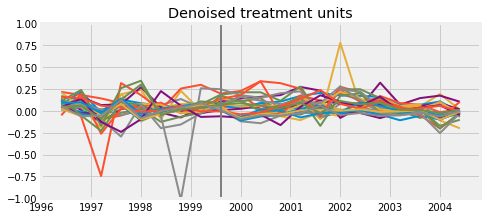

<IPython.core.display.Javascript object>

In [401]:
plt.figure(figsize=(7, 3))
for treat in treats:
    rsc_model = RobustSyntheticControl(
        treat,
        num_singular_values,
        len(train[controls]),
        probObservation=1.0,
        modelType="svd",
        svdMethod="numpy",
        otherSeriesKeysArray=controls,
    )
    rsc_model.fit(train[controls + [treat]])
    train_denoised = rsc_model.model.denoisedDF()
    train_denoised.index = train.index

    # Compute counterfactuals
    pred = pd.Series(np.dot(data[controls], rsc_model.model.weights))
    pred.index = data.index
    plt.plot(pred.index, data[treat] - pred)
    plt.gca().set_xticklabels(pred.index)

plt.ylim(-1, 1)
plt.title("Denoised treatment units")
plt.axvline(valid_year, color="grey")

In [332]:
def estimator_variance(treatment_size, treatment_variance, prediction_error_variance):
    return (treatment_variance + prediction_error_variance) / treatment_size


def make_counterfactuals(train, valid, controls, treat):
    rsc_model = RobustSyntheticControl(
        treat,
        num_singular_values,
        len(train),
        probObservation=1.0,
        modelType="svd",
        svdMethod="numpy",
        otherSeriesKeysArray=controls,
    )
    rsc_model.fit(train[controls + [treat]])
    train_denoised = rsc_model.model.denoisedDF()
    train_denoised.index = train.index
    pred = pd.Series(np.dot(valid[controls], rsc_model.model.weights))
    return pred

<IPython.core.display.Javascript object>

### Greedy Algorithm

In [487]:
from sklearn.linear_model import Lasso


def run_test(train, valid, mean_effect=0, std_effect=1, random=False, plot=True):
    var_effect = std_effect ** 2
    if plot:
        plt.figure(figsize=(10, 4))
        plt.title("Greedy Algo - Normal({}, {})".format(mean_effect, std_effect))
        plt.xlabel("# Treatment Units")
        plt.xlim(1, max_units), plt.xticks(range(1, max_units + 1))

    C, T = set(train.columns), set({})
    tracker = []
    var_errors, var_treats, var_totals = [], [], []
    for i in range(max_units - 1):
        units_errs = []
        for unit in C:
            treats = list(T.union({unit}))
            controls = list(C - {unit})
            errors_all = []
            for treat in treats:
                lr.fit(train[controls], train[treat])
                pred = lr.predict(valid[controls].values)
                errors = (pred - valid[treat].values) ** 2
                errors_all += errors.tolist()
            units_errs.append((unit, np.sum(errors_all)))

        if random:
            random_idx = np.random.randint(0, len(units_errs))
            min_unit, min_err = units_errs[random_idx]
        else:
            min_unit, min_err = min(units_errs, key=lambda x: x[1])

        new_controls = list(C - {min_unit})
        new_treats = list(T.union({min_unit}))
        errors_all = []
        for treat in new_treats:
            lr.fit(train[new_controls], train[treat])
            pred = lr.predict(test[new_controls].values)
            errors = (pred - test[treat].values) ** 2
            errors_all += errors.tolist()
        var_error = np.sum(errors_all) / len(treats) / len(valid)
        var_treat = var_effect / len(treats) / len(valid)
        var_total = var_error + var_treat
        units.append(min_unit)
        var_errors.append(var_error / var_effect)
        var_treats.append(var_treat / var_effect)
        var_totals.append(var_total / var_effect)

        T.add(min_unit)
        C.remove(min_unit)

        if not plot:
            print(i, end="")
        elif i > 2:
            if i > 3:
                plt.gca().lines.pop(), plt.gca().lines.pop(), plt.gca().lines.pop()
            if i == 3:
                plt.ylim(-max(var_totals) * 0.05, max(0.5, max(var_totals) * 1))

            plt.plot(range(1, i + 2), var_treats, label="var_TreatError", c="b")
            plt.plot(range(1, i + 2), var_errors, label="var_PredError", c="r")
            plt.plot(range(1, i + 2), var_totals, c="black", label="var_Total")
            display.clear_output(wait=True)
            plt.legend()
            display.display(plt.gcf())
    if plot:
        display.clear_output(wait=True)
    return var_treats, var_errors, var_totals

<IPython.core.display.Javascript object>

In [488]:
from sklearn.linear_model import Lasso


def run(train, valid, mean_effect=0, std_effect=1, random=False, plot=True):
    var_effect = std_effect ** 2
    if plot:
        plt.figure(figsize=(10, 4))
        plt.title("Greedy Algo - Normal({}, {})".format(mean_effect, std_effect))
        plt.xlabel("# Treatment Units")
        plt.xlim(1, max_units), plt.xticks(range(1, max_units + 1))

    lr = Lasso(alpha=0.01, fit_intercept=False, positive=True)
    C, T = set(train.columns), set({})
    tracker = []
    var_errors, var_treats, var_totals = [], [], []
    for i in range(max_units - 1):
        units_and_errs = []
        for unit in C:
            treats = list(T.union({unit}))
            controls = list(C - {unit})
            errors_all = []
            for treat in treats:
                # pred = make_counterfactuals(train, valid, controls, treat).values
                lr.fit(train[controls], train[treat])
                pred = lr.predict(valid[controls].values)
                errors = (pred - valid[treat].values) ** 2
                errors_all += errors.tolist()
            units_and_errs.append((unit, np.sum(errors_all)))

        if random:
            random_idx = np.random.randint(0, len(units_and_errs))
            min_unit, min_err = units_and_errs[random_idx]
        else:
            min_unit, min_err = min(units_and_errs, key=lambda x: x[1])

        var_error = min_err / len(treats) / len(valid)
        var_treat = var_effect / len(treats) / len(valid)
        var_total = var_error + var_treat
        units.append(min_unit)
        var_errors.append(var_error / var_effect)
        var_treats.append(var_treat / var_effect)
        var_totals.append(var_total / var_effect)

        T.add(min_unit)
        C.remove(min_unit)

        if not plot:
            print(i, end="")
        elif i > 2:
            if i > 3:
                plt.gca().lines.pop(), plt.gca().lines.pop(), plt.gca().lines.pop()
            if i == 3:
                plt.ylim(-max(var_totals) * 0.05, max(1, max(var_totals) * 1))

            plt.plot(range(1, i + 2), var_treats, label="var_TreatError", c="b")
            plt.plot(range(1, i + 2), var_errors, label="var_PredError", c="r")
            plt.plot(range(1, i + 2), var_totals, c="black", label="var_Total")
            display.clear_output(wait=True)
            plt.legend()
            display.display(plt.gcf())
    if plot:
        mini = (np.argmin(var_totals), min(var_totals))
        plt.scatter(
            [mini[0]], [mini[1]], marker="x", color="green", s=10 ** 2, zorder=10
        )
        display.clear_output(wait=True)
    return var_treats, var_errors, var_totals

<IPython.core.display.Javascript object>

In [493]:
var_treats, var_errors, var_totals = run_test(
    train,
    valid,
    mean_effect=0,
    std_effect=0.05,
    random=False,
    plot=False,
)

rands = []
for i in range(5):
    var_treats_rand, var_errors_rand, var_totals_rand = run_test(
        train,
        valid,
        mean_effect=0,
        std_effect=0.05,
        random=True,
        plot=False,
    )
    rands.append((var_treats_rand, var_errors_rand, var_totals_rand))

012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728

<IPython.core.display.Javascript object>

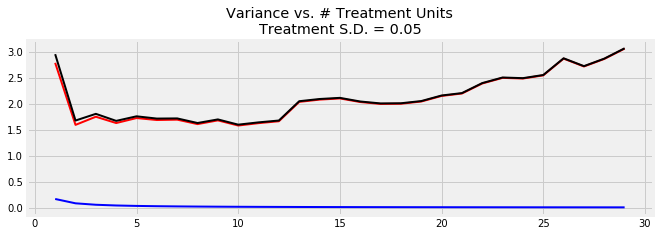

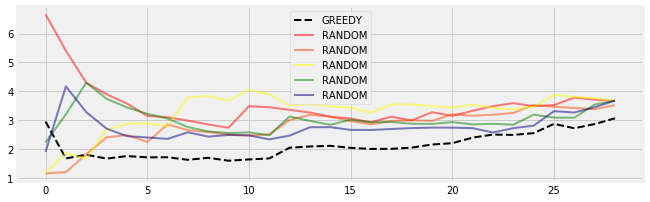

<IPython.core.display.Javascript object>

In [494]:
# PLOT
plt.figure(figsize=(10, 3))
x = range(1, len(var_treats) + 1)
plt.plot(x, var_treats, c="b", label="Treatment")
plt.plot(x, var_errors, c="r", label="PredictionError")
plt.plot(x, var_totals, c="black", label="Total")
plt.title("Variance vs. # Treatment Units\nTreatment S.D. = {}".format(0.05))

plt.figure(figsize=(10, 3))
plt.plot(var_totals, c="black", label="GREEDY", linestyle="--")
colors = ["red", "orangered", "yellow", "g", "navy"]
for c, (_, var_errors_rand, var_totals_rand) in zip(colors, rands):
    c2 = "orangered"
    plt.plot(var_totals_rand, c=c, alpha=0.5, label="RANDOM")
plt.legend()

In [495]:
var_treats, var_errors, var_totals = run_test(
    train,
    valid,
    mean_effect=0,
    std_effect=0.25,
    random=False,
    plot=False,
)

rands = []
for i in range(5):
    var_treats_rand, var_errors_rand, var_totals_rand = run_test(
        train,
        valid,
        mean_effect=0,
        std_effect=0.25,
        random=True,
        plot=False,
    )
    rands.append((var_treats_rand, var_errors_rand, var_totals_rand))

012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728

<IPython.core.display.Javascript object>

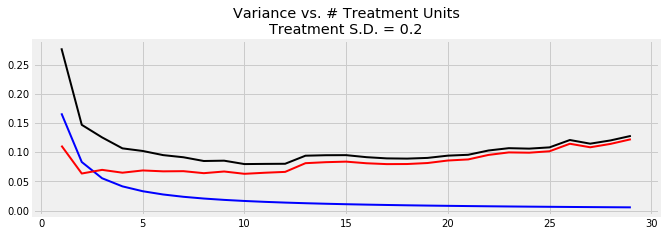

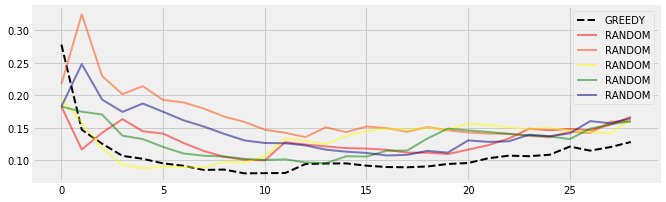

<IPython.core.display.Javascript object>

In [496]:
# PLOT
plt.figure(figsize=(10, 3))
x = range(1, len(var_treats) + 1)
plt.plot(x, var_treats, c="b", label="Treatment")
plt.plot(x, var_errors, c="r", label="PredictionError")
plt.plot(x, var_totals, c="black", label="Total")
plt.title("Variance vs. # Treatment Units\nTreatment S.D. = {}".format(0.20))

plt.figure(figsize=(10, 3))
plt.plot(var_totals, c="black", label="GREEDY", linestyle="--")
colors = ["red", "orangered", "yellow", "g", "navy"]
for c, (_, var_errors_rand, var_totals_rand) in zip(colors, rands):
    c2 = "orangered"
    plt.plot(var_totals_rand, c=c, alpha=0.5, label="RANDOM")
plt.legend()

In [497]:
var_treats, var_errors, var_totals = run_test(
    train,
    valid,
    mean_effect=0,
    std_effect=0.5,
    random=False,
    plot=False,
)

rands = []
for i in range(5):
    var_treats_rand, var_errors_rand, var_totals_rand = run_test(
        train,
        valid,
        mean_effect=0,
        std_effect=0.5,
        random=True,
        plot=False,
    )
    rands.append((var_treats_rand, var_errors_rand, var_totals_rand))

012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728012345678910111213141516171819202122232425262728

<IPython.core.display.Javascript object>

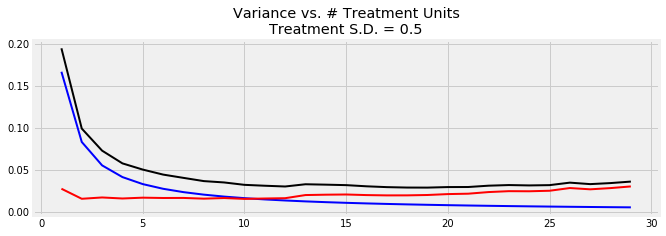

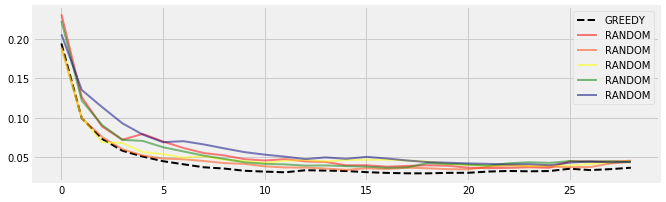

<IPython.core.display.Javascript object>

In [498]:
# PLOT
plt.figure(figsize=(10, 3))
x = range(1, len(var_treats) + 1)
plt.plot(x, var_treats, c="b", label="Treatment")
plt.plot(x, var_errors, c="r", label="PredictionError")
plt.plot(x, var_totals, c="black", label="Total")
plt.title("Variance vs. # Treatment Units\nTreatment S.D. = {}".format(0.50))

plt.figure(figsize=(10, 3))
plt.plot(var_totals, c="black", label="GREEDY", linestyle="--")
colors = ["red", "orangered", "yellow", "g", "navy"]
for c, (_, var_errors_rand, var_totals_rand) in zip(colors, rands):
    c2 = "orangered"
    plt.plot(var_totals_rand, c=c, alpha=0.5, label="RANDOM")
plt.legend()

Text(0.5, 1.0, 'Variance vs. # Treatment Units\nTreatment S.D. = 0.5')

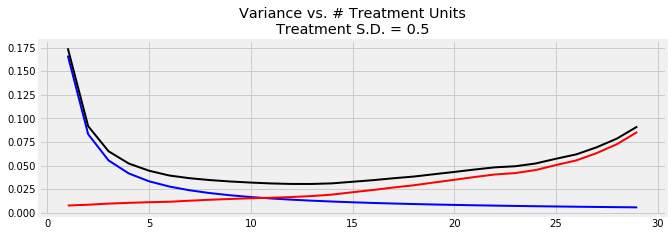

<IPython.core.display.Javascript object>

In [473]:
plt.figure(figsize=(10, 3))
x = range(1, len(var_treats) + 1)
plt.plot(x, var_treats, c="b", label="Treatment")
plt.plot(x, var_errors, c="r", label="PredictionError")
plt.plot(x, var_totals, c="black", label="Total")
plt.title("Variance vs. # Treatment Units\nTreatment S.D. = {}".format(0.50))

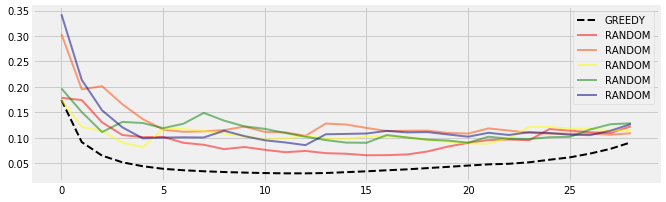

<IPython.core.display.Javascript object>

In [459]:
plt.figure(figsize=(10, 3))

plt.plot(var_totals, c="black", label="GREEDY", linestyle="--")
colors = ["red", "orangered", "yellow", "g", "navy"]
for c, (_, var_errors_rand, var_totals_rand) in zip(colors, rands):
    c2 = "orangered"
    plt.plot(var_totals_rand, c=c, alpha=0.5, label="RANDOM")
plt.legend()

Text(0.5, 1.0, 'Variance vs. # Treatment Units\nTreatment S.D. = 0.05')

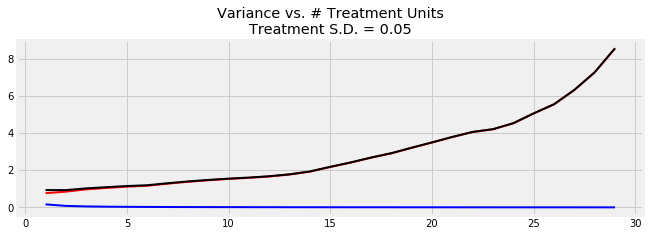

<IPython.core.display.Javascript object>

In [441]:
plt.figure(figsize=(10, 3))

x = range(1, len(var_treats) + 1)
plt.plot(x, var_treats, c="b", label="Treatment")
plt.plot(x, var_errors, c="r", label="PredictionError")
plt.plot(x, var_totals, c="black", label="Total")
plt.title("Variance vs. # Treatment Units\nTreatment S.D. = {}".format(0.05))

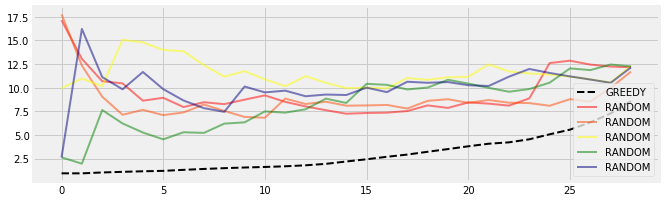

<IPython.core.display.Javascript object>

In [442]:
plt.figure(figsize=(10, 3))

c1 = "black"
plt.plot(var_totals, c=c1, label="GREEDY", linestyle="--")

colors = ["red", "orangered", "yellow", "g", "navy"]
for c, (_, var_errors_rand, var_totals_rand) in zip(colors, rands):
    c2 = "orangered"
    # plt.plot(var_errors_rand, c=c, alpha=0.2)
    plt.plot(var_totals_rand, c=c, alpha=0.5, label="RANDOM")

plt.legend()

### Archive

In [133]:
pred = pd.Series(np.dot(data[controls], rsc_model.model.weights))
pred.index = data.index
plt.figure(figsize=(10,2))
plt.plot(pred)
plt.plot(data[treat], linestyle='--')
plt.xticks(data.index)
plt.axvline(treat_year, color='grey')
#np.mean(train_pred - train[treat].values)/train[treat].values.mean()

ValueError: shapes (21,0) and (14,) not aligned: 0 (dim 1) != 14 (dim 0)

In [ ]:
std = 0.2
z = d['White'].iloc[:T]/d['White'].max()#np.log(np.linspace(10,20,T))
X = np.array([
    (min_beta + (1-min_beta)*rand.rand())*(z+z*std*rand.randn(T))
    for _ in range(N)]).T

In [ ]:
xt

In [ ]:
# 1


treatmt_time = 10
num_treatmt = 5
treatmt_idx = np.random.choice(range(0,N), num_treatmt, replace=False)
control_idx = list(set(range(0,N)) - set(treatmt_idx))
num_control = len(control_idx)

RSS = []
for treatmt_unit in treatmt_idx:
    w0 = np.array([1.0/num_control]*num_control)
    v = [1.0/num_control]*num_control
    x1 = X[:, treatmt_unit]
    x0 = X[:, control_idx]
    z1 = X[treatmt_time:, treatmt_unit]
    z0 = X[treatmt_time:, control_idx]
    
    res = get_w(w0, v, x0, x1)
    w = res[0]
    RSS.append(res[1])
#     plt.plot(x1, linewidth=2);
#     plt.plot(np.dot(x0, w), linewidth=2, linestyle='--');
#     plt.plot(x0, c='grey', alpha=0.5);
#     plt.show()


In [ ]:
from scipy.optimize import fmin_slsqp
def get_w(w, v, x0, x1):
    result = fmin_slsqp(w_rss, w,
                        #f_eqcons=w_constraint,
                        bounds=[(0.0, 1.0)]*len(w),
             args=(v, x0, x1), disp=False, full_output=True)
    weights = result[0]
    return result

def get_v_0(v, w, x0, x1, z0, z1):
    weights = fmin_slsqp(w_rss, w, f_eqcons=w_constraint, bounds=[(0.0, 1.0)]*len(w),
             args=(v, x0, x1), disp=False, full_output=True)[0]
    rss = v_rss(weights, z0, z1)
    return rss

def get_v_1(v, w, x0, x1, z0, z1):
    result = minimize(get_v_0, v, args=(w, x0, x1, z0, z1), bounds=[(0.0, 1.0)]*len(v))
    importance = result.x
    return importance

# Helpers
def w_rss(w, v, x0, x1):
    k = len(x1)
    importance = np.zeros((k,k))
    np.fill_diagonal(importance, v)
    predictions = np.dot(x0, w)
    errors = x1 - predictions
    weighted_errors = np.dot(errors.transpose(), importance)
    weighted_rss = np.dot(weighted_errors,errors).item(0)
    return weighted_rss

def w_constraint(w, v, x0, x1):
    return np.sum(w) - 1